In [1]:
pip install pandas numpy xgboost==3.1.1 scikit-learn joblib

Note: you may need to restart the kernel to use updated packages.



    ╔═══════════════════════════════════════════════════════════════════╗
    ║   Electricity Demand Forecasting - Quick Deployment Test         ║
    ║   Model: XGBoost Tuned v1.0                                       ║
    ║   Team: CloudAikes                                                ║
    ╚═══════════════════════════════════════════════════════════════════╝
    

🧪 QUICK DEPLOYMENT TEST
✅ Model loaded successfully from: xgb_tuned_model_20251107_134336.pkl
   Model type: XGBRegressor

📝 Test Case 1: Weekday Noon Prediction
----------------------------------------------------------------------
Input: Weekday (Wed) at 12:00, Period=24
Predicted Demand: 33,535.88 MW
Confidence Range: [31,297.00, 35,774.76] MW
✅ Prediction in reasonable range (20-50 GW)

📝 Test Case 2: Weekend Evening Prediction
----------------------------------------------------------------------
Input: Weekend (Sat) at 20:00, Period=40
Predicted Demand: 34,260.31 MW
Confidence Range: [32,021.43, 36,499.19] MW



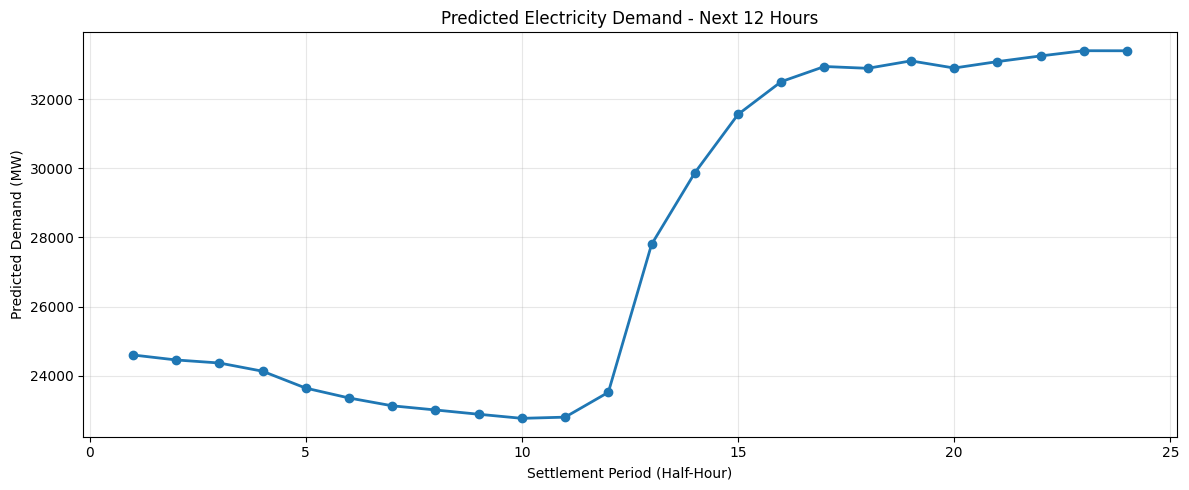

In [7]:
"""
Quick Start Deployment Script for Electricity Demand Forecasting
Author: Tuur (CloudAikes)
For: Natan (Deployment)

This script provides a minimal working example to test the model deployment.
"""

import pandas as pd
import numpy as np
import joblib
from datetime import datetime, timedelta

# ============================================================================
# 1. PREPROCESSING FUNCTION (COPY THIS TO YOUR DEPLOYMENT)
# ============================================================================

def preprocess_input_data(df):
    """
    Preprocess input data for model inference.
    CRITICAL: This must match the training preprocessing exactly.
    """
    df = df.copy()
    
    # Handle datetime if present
    if 'settlement_date' in df.columns:
        df['settlement_date'] = pd.to_datetime(df['settlement_date'])
        
        # Extract time features (only those used in training)
        if 'year' not in df.columns:
            df['year'] = df['settlement_date'].dt.year
        if 'month' not in df.columns:
            df['month'] = df['settlement_date'].dt.month
        if 'day' not in df.columns:
            df['day'] = df['settlement_date'].dt.day
        if 'dayofweek' not in df.columns:
            df['dayofweek'] = df['settlement_date'].dt.dayofweek
        if 'week' not in df.columns:
            df['week'] = df['settlement_date'].dt.isocalendar().week
        if 'is_weekend' not in df.columns:
            df['is_weekend'] = (df['settlement_date'].dt.dayofweek >= 5).astype(int)
    
    # Remove excluded features (DATA LEAKAGE + unused features)
    excluded = ['settlement_date', 'england_wales_demand', 'nd', 'tsd', 'hour', 'quarter']
    for col in excluded:
        if col in df.columns:
            df = df.drop(columns=[col])
    
    # Handle missing values for interconnector flows
    flow_features = ['scottish_transfer', 'ifa_flow', 'ifa2_flow', 'britned_flow', 
                     'moyle_flow', 'east_west_flow', 'nemo_flow', 
                     'nsl_flow', 'eleclink_flow', 'viking_flow', 'greenlink_flow']
    
    for col in flow_features:
        if col in df.columns:
            df[col] = df[col].fillna(0)
    
    # Handle missing values for renewable features
    renewable_features = ['embedded_wind_generation', 'embedded_solar_generation',
                         'embedded_wind_capacity', 'embedded_solar_capacity']
    
    for col in renewable_features:
        if col in df.columns:
            df[col] = df[col].fillna(0)
    
    # Ensure correct data types
    df['settlement_period'] = df['settlement_period'].astype(int)
    df['year'] = df['year'].astype(int)
    df['month'] = df['month'].astype(int)
    df['day'] = df['day'].astype(int)
    df['dayofweek'] = df['dayofweek'].astype(int)
    df['week'] = df['week'].astype(int)
    df['is_weekend'] = df['is_weekend'].astype(int)
    
    # Ensure correct feature order (matches training)
    expected_features = [
        'settlement_period', 'embedded_wind_generation', 'embedded_wind_capacity',
        'embedded_solar_generation', 'embedded_solar_capacity', 'non_bm_stor',
        'pump_storage_pumping', 'scottish_transfer', 'ifa_flow', 'ifa2_flow',
        'britned_flow', 'moyle_flow', 'east_west_flow', 'nemo_flow', 'nsl_flow',
        'eleclink_flow', 'viking_flow', 'greenlink_flow', 'year', 'month', 'day',
        'dayofweek', 'week', 'is_weekend'
    ]
    
    # Select only available features in correct order
    available_features = [col for col in expected_features if col in df.columns]
    df = df[available_features]
    
    return df


# ============================================================================
# 2. LOAD MODEL
# ============================================================================

def load_model(model_path='xgb_tuned_model_20251107_134336.pkl'):
    """Load the trained XGBoost model."""
    try:
        model = joblib.load(model_path)
        print(f"✅ Model loaded successfully from: {model_path}")
        print(f"   Model type: {type(model).__name__}")
        return model
    except FileNotFoundError:
        print(f"❌ ERROR: Model file not found at {model_path}")
        print("   Make sure to copy the .pkl file to the same directory as this script!")
        return None
    except Exception as e:
        print(f"❌ ERROR loading model: {e}")
        return None


# ============================================================================
# 3. PREDICTION FUNCTIONS
# ============================================================================

def predict_single(model, input_data):
    """
    Make a single prediction.
    
    Args:
        model: Loaded XGBoost model
        input_data: dict or DataFrame with required features
        
    Returns:
        dict: Prediction result with confidence interval
    """
    if isinstance(input_data, dict):
        input_data = pd.DataFrame([input_data])
    
    # Preprocess
    input_processed = preprocess_input_data(input_data)
    
    # Predict
    prediction = model.predict(input_processed)[0]
    
    # Add confidence interval (±1 RMSE)
    rmse = 2238.88  # From model training
    
    return {
        'predicted_demand_mw': float(prediction),
        'confidence_interval_lower': float(prediction - rmse),
        'confidence_interval_upper': float(prediction + rmse),
        'model_version': 'xgb_tuned_v1.0'
    }


def predict_batch(model, input_data):
    """
    Make batch predictions.
    
    Args:
        model: Loaded XGBoost model
        input_data: DataFrame with multiple rows
        
    Returns:
        np.array: Predictions for each row
    """
    # Preprocess
    input_processed = preprocess_input_data(input_data)
    
    # Predict
    predictions = model.predict(input_processed)
    
    return predictions


# ============================================================================
# 4. EXAMPLE USAGE / QUICK TEST
# ============================================================================

def test_deployment():
    """
    Quick test to verify deployment works correctly.
    """
    print("\n" + "="*70)
    print("🧪 QUICK DEPLOYMENT TEST")
    print("="*70)
    
    # Load model
    model = load_model()
    if model is None:
        return False
    
    # Test case 1: Single prediction with typical weekday noon values
    print("\n📝 Test Case 1: Weekday Noon Prediction")
    print("-" * 70)
    
    test_input_1 = {
        'settlement_period': 24,      # Noon
        'year': 2025,
        'month': 11,
        'day': 13,                     # Wednesday
        'dayofweek': 2,                # Wednesday
        'week': 46,
        'is_weekend': 0,
        'embedded_wind_generation': 5000.0,
        'embedded_wind_capacity': 15000.0,
        'embedded_solar_generation': 3000.0,
        'embedded_solar_capacity': 14000.0,
        'non_bm_stor': 500,
        'pump_storage_pumping': 200,
        'scottish_transfer': 2000.0,
        'ifa_flow': 1000,
        'ifa2_flow': 0.0,
        'britned_flow': 500.0,
        'moyle_flow': 300.0,
        'east_west_flow': 0.0,
        'nemo_flow': 0.0,
        'nsl_flow': 0.0,
        'eleclink_flow': 0.0,
        'viking_flow': 0.0,
        'greenlink_flow': 0.0
    }
    
    result_1 = predict_single(model, test_input_1)
    
    print(f"Input: Weekday (Wed) at 12:00, Period={test_input_1['settlement_period']}")
    print(f"Predicted Demand: {result_1['predicted_demand_mw']:,.2f} MW")
    print(f"Confidence Range: [{result_1['confidence_interval_lower']:,.2f}, "
          f"{result_1['confidence_interval_upper']:,.2f}] MW")
    
    # Sanity check
    if 20000 < result_1['predicted_demand_mw'] < 50000:
        print("✅ Prediction in reasonable range (20-50 GW)")
    else:
        print("⚠️  WARNING: Prediction outside typical UK demand range!")
    
    # Test case 2: Weekend evening (lower demand expected)
    print("\n📝 Test Case 2: Weekend Evening Prediction")
    print("-" * 70)
    
    test_input_2 = {
        'settlement_period': 40,       # Evening (20:00)
        'year': 2025,
        'month': 11,
        'day': 16,                     # Saturday
        'dayofweek': 5,                # Saturday
        'week': 46,
        'is_weekend': 1,               # Weekend!
        'embedded_wind_generation': 8000.0,  # More wind
        'embedded_wind_capacity': 15000.0,
        'embedded_solar_generation': 0.0,    # Night = no solar
        'embedded_solar_capacity': 14000.0,
        'non_bm_stor': 400,
        'pump_storage_pumping': 150,
        'scottish_transfer': 1800.0,
        'ifa_flow': 800,
        'ifa2_flow': 0.0,
        'britned_flow': 400.0,
        'moyle_flow': 250.0,
        'east_west_flow': 0.0,
        'nemo_flow': 0.0,
        'nsl_flow': 0.0,
        'eleclink_flow': 0.0,
        'viking_flow': 0.0,
        'greenlink_flow': 0.0
    }
    
    result_2 = predict_single(model, test_input_2)
    
    print(f"Input: Weekend (Sat) at 20:00, Period={test_input_2['settlement_period']}")
    print(f"Predicted Demand: {result_2['predicted_demand_mw']:,.2f} MW")
    print(f"Confidence Range: [{result_2['confidence_interval_lower']:,.2f}, "
          f"{result_2['confidence_interval_upper']:,.2f}] MW")
    
    # Compare results
    print("\n📊 Comparison:")
    print(f"Weekday demand: {result_1['predicted_demand_mw']:,.2f} MW")
    print(f"Weekend demand: {result_2['predicted_demand_mw']:,.2f} MW")
    print(f"Difference:     {result_1['predicted_demand_mw'] - result_2['predicted_demand_mw']:,.2f} MW")
    
    # Test case 3: Batch prediction
    print("\n📝 Test Case 3: Batch Prediction (Next 24 hours)")
    print("-" * 70)
    
    # Generate 48 half-hourly predictions for next day
    base_date = datetime(2025, 11, 14, 0, 0)  # Start of tomorrow
    batch_data = []
    
    for period in range(1, 25):  # First 24 periods (12 hours)
        time = base_date + timedelta(minutes=30*(period-1))
        batch_data.append({
            'settlement_period': period,
            'year': time.year,
            'month': time.month,
            'day': time.day,
            'dayofweek': time.weekday(),
            'week': time.isocalendar()[1],
            'is_weekend': 1 if time.weekday() >= 5 else 0,
            'embedded_wind_generation': 6000.0,
            'embedded_wind_capacity': 15000.0,
            'embedded_solar_generation': max(0, 3000 * np.sin(np.pi * period / 48)),
            'embedded_solar_capacity': 14000.0,
            'non_bm_stor': 500,
            'pump_storage_pumping': 200,
            'scottish_transfer': 2000.0,
            'ifa_flow': 1000,
            'ifa2_flow': 0.0,
            'britned_flow': 500.0,
            'moyle_flow': 300.0,
            'east_west_flow': 0.0,
            'nemo_flow': 0.0,
            'nsl_flow': 0.0,
            'eleclink_flow': 0.0,
            'viking_flow': 0.0,
            'greenlink_flow': 0.0
        })
    
    batch_df = pd.DataFrame(batch_data)
    batch_predictions = predict_batch(model, batch_df)
    
    print(f"Generated {len(batch_predictions)} predictions")
    print(f"Mean demand:    {batch_predictions.mean():,.2f} MW")
    print(f"Min demand:     {batch_predictions.min():,.2f} MW")
    print(f"Max demand:     {batch_predictions.max():,.2f} MW")
    print(f"Std deviation:  {batch_predictions.std():,.2f} MW")
    
    # Visualize if matplotlib available
    try:
        import matplotlib.pyplot as plt
        
        plt.figure(figsize=(12, 5))
        plt.plot(range(1, 25), batch_predictions, marker='o', linewidth=2)
        plt.xlabel('Settlement Period (Half-Hour)')
        plt.ylabel('Predicted Demand (MW)')
        plt.title('Predicted Electricity Demand - Next 12 Hours')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('prediction_test_plot.png', dpi=150)
        print("\n📊 Plot saved: prediction_test_plot.png")
    except:
        print("\n⚠️  Matplotlib not available, skipping plot")
    
    print("\n" + "="*70)
    print("✅ ALL TESTS PASSED - DEPLOYMENT READY!")
    print("="*70)
    
    return True


# ============================================================================
# 5. VALIDATION FUNCTION (Optional but recommended)
# ============================================================================

def validate_against_test_set(model, test_data_path):
    """
    Validate deployed model against original test set.
    This ensures model performance hasn't degraded.
    """
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    
    print("\n" + "="*70)
    print("🧪 VALIDATION AGAINST TEST SET")
    print("="*70)
    
    try:
        # Load test data
        df_test = pd.read_csv(test_data_path)
        print(f"✅ Loaded test data: {len(df_test)} rows")
        
        # Separate target
        if 'nd' not in df_test.columns:
            print("❌ ERROR: 'nd' (target) column not found in test data")
            return False
        
        y_true = df_test['nd']
        X_test = df_test.drop(columns=['nd'])
        
        # Preprocess and predict
        X_test_processed = preprocess_input_data(X_test)
        y_pred = model.predict(X_test_processed)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        
        print(f"\n📊 Validation Results:")
        print(f"   RMSE: {rmse:,.2f} MW")
        print(f"   MAE:  {mae:,.2f} MW")
        print(f"   R²:   {r2:.4f}")
        
        # Compare to expected
        print(f"\n📊 Expected Performance (from training):")
        print(f"   RMSE: 2,238.88 MW")
        print(f"   R²:   0.8697")
        
        print(f"\n📊 Difference:")
        print(f"   RMSE: {abs(rmse - 2238.88):,.2f} MW")
        print(f"   R²:   {abs(r2 - 0.8697):.4f}")
        
        # Validation checks
        if abs(rmse - 2238.88) < 500 and abs(r2 - 0.8697) < 0.05:
            print("\n✅ VALIDATION PASSED - Performance matches training!")
            return True
        else:
            print("\n⚠️  WARNING - Performance differs from training")
            print("   This could indicate:")
            print("   - Different preprocessing")
            print("   - Model version mismatch")
            print("   - Data distribution shift")
            return False
            
    except FileNotFoundError:
        print(f"❌ ERROR: Test data file not found at {test_data_path}")
        print("   Skipping validation (optional)")
        return None
    except Exception as e:
        print(f"❌ ERROR during validation: {e}")
        return False


# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("""
    ╔═══════════════════════════════════════════════════════════════════╗
    ║   Electricity Demand Forecasting - Quick Deployment Test         ║
    ║   Model: XGBoost Tuned v1.0                                       ║
    ║   Team: CloudAikes                                                ║
    ╚═══════════════════════════════════════════════════════════════════╝
    """)
    
    # Run quick test
    success = test_deployment()
    
    # Optional: Validate against test set if available
    print("\n" + "="*70)
    print("Optional: Validate against original test set?")
    print("="*70)
    print("If you have the cleaned data file (demand_data_cleaned.csv),")
    print("uncomment the line below to run full validation:")
    print()
    print("# validate_against_test_set(model, '../data/processed/demand_data_cleaned.csv')")
    
    if success:
        print("\n🎉 Deployment test completed successfully!")
    else:
        print("\n❌ Deployment test failed - check errors above")